# FER




# Mount Drive:

In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Set Paths:

In [ ]:
PATH_STATS = '/content/gdrive/MyDrive/DS/Second Year - First Semster/AML/homeworks/final project/stats/'
PATH_MODELS = '/content/gdrive/MyDrive/DS/Second Year - First Semster/AML/homeworks/final project/models/'
PATH_FIG = '/content/gdrive/MyDrive/DS/Second Year - First Semster/AML/homeworks/final project/figures/'
PATH_DATA = '/content/FER/'

# Get Datset From Kaggle

As first step we install the libraries needed and load the key.
Then we can start the download from kaggle and unzip.

In [ ]:
from google.colab import files
# Install Kaggle library
!pip install -q kaggle
# Upload kaggle API key file
uploaded = files.upload()
# create the needed directory
! mkdir ~/.kaggle
# Copy the file to the dir
! cp kaggle.json ~/.kaggle/
# Change permissions:
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d msambare/fer2013

 81% 49.0M/60.3M [00:00<00:00, 96.5MB/s]
100% 60.3M/60.3M [00:00<00:00, 136MB/s] 


In [ ]:
%%capture
! unzip fer2013.zip -d FER
! rm fer2013.zip

# Get Validation

In [ ]:
import os
import shutil
import numpy as np

In [ ]:
def create_valid(path_data):
  np.random.seed(123)
  dest = path_data + 'valid/'
  if not os.path.isdir(dest):
      
    source = path_data + 'train/'
    os.mkdir(dest)

    folders = os.listdir(source)
    for fold in folders:
      in_path = source + fold + '/'
      out_path = dest + fold + '/'
      if not os.path.isdir(out_path):
        os.mkdir(out_path)
      for img in os.listdir(in_path):
        if np.random.rand(1) < 0.1:
            shutil.move(in_path + img, out_path + img)

In [ ]:
create_valid(PATH_DATA)

# Data Augmentation Classes:

In [ ]:
%%capture
!pip install git+https://github.com/aleju/imgaug

In [ ]:
%%capture
# Library for DA:
from torchvision import transforms
import torch

# Color Transformations:
from imgaug import augmenters as iaa
import imgaug as ia

# Load and work with images:
from PIL import Image
import cv2
import numpy as np

In [ ]:
# Transformation to preprocess during validation:
class HistEqualization(object):
  '''
  This class adjust the illumination of the picture
  '''
  def __call__(self, img):
    img = np.array(img)
    grayimg = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    equ = cv2.equalizeHist(grayimg) 

    return Image.fromarray(equ).convert('RGB')

In [ ]:
# Colors Custom Transform:
class RandomErasing:
  def __init__(self, max_n, size):
    self.aug = iaa.Sequential([iaa.Cutout(nb_iterations=(1, max_n), size=size, squared=False, fill_mode='gaussian')])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

# Data Loading:


In [ ]:
%%capture
# Libraries to load data:
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import cv2

# Library to modify:
import numpy as np

In [ ]:
def define_weights(data, path_data):
  '''
  This function returns a set of weights for the data loader
    Args:
      data (ImageFolder): a preprocessed folder by pytorch
      path_data (str): the path to the folder containing train and test data
    Out:
      tensor containing the weights
  '''
  
  labels = torch.IntTensor(data.targets)
  class_count = torch.bincount(torch.IntTensor(data.targets))
  N = torch.sum(labels)
  relative_w = N / class_count
  weights = relative_w[labels.tolist()]
    
  return weights

In [ ]:
# Define function to Load and Process Data:
def CustomDataLoader(path, transformations=None,  batch_size=120, as_df='train', balanced=True):

  """"
  This function loads deta, split in train and validation if needed, transform the data and
  prepare for the data loader, adding transformations.
    Args:
      path (str): a tring containing the path to the folder of data
      transformations (lst): a list as transform.COmopose of transformations
      btach_size (int): size of the batch
      as_df (str): which df you want to load, three possibilities (train, valid, test)
    Out:
      data.a_loader (data_loader): a dataset ready to be passed in the net
  """

  # Load Data:
  if balanced:
    if as_df == 'train':
      data = ImageFolder(root=path + 'train/', transform= transformations)
      # Define weights for classes:
      weights = define_weights(data, path + 'train/')                                                                                                
      sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(data)) 
      # Load Data:
      train = DataLoader(data, batch_size=batch_size, sampler=sampler, pin_memory=True)
      return train
    elif as_df == 'valid':
      data = ImageFolder(root=path + 'valid/', transform= transformations) 
      valid = DataLoader(data, batch_size=batch_size, pin_memory=True)
      return valid
    elif as_df == 'test':
      data = ImageFolder(root=path + 'test/', transform= transformations)             
      test = DataLoader(data, batch_size=batch_size, pin_memory=True)
      return test    

  else:
    if as_df == 'train':
      data = ImageFolder(path + 'train/', transform= transformations)
      train = DataLoader(data, batch_size=batch_size, shuffle=True, pin_memory=True)
      return train
    elif as_df == 'valid':
      data = ImageFolder(path + 'valid/', transform= transformations)
      valid = DataLoader(data, batch_size=batch_size, shuffle=False, pin_memory=True) 
      return valid 
    elif as_df == 'test':
      data = ImageFolder(root=path + 'test/', transform= transformations)             
      test = DataLoader(data, batch_size=batch_size, pin_memory=True)
      return test                                                                      


# Common Functions For the Models
Useful tools to compute and save statistics and to work on the model

In [ ]:
import torch

# Helpful tools:
from time import time
import pandas as pd
import numpy as np
# Plot\ results:
import matplotlib.pyplot as plt
import seaborn as sns

# Write CSV:
import csv
import os

# For evaluation:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

# Metrics:
from sklearn.metrics import classification_report

In [ ]:
# Plot a sample from our train:
def plot_pic(n, loader):
  '''
  This function plot n pictures processed.
    Args:
      n (int): number of features to show
      loader : a data loader made by pytorch
  '''

  for i in range(n):

    # Select sample:

    x, y = next(iter(loader))

    # Plot:
    plt.subplot(1,3,i+1)
    plt.imshow(x[i].permute(1,2,0))
    plt.title('Class: ' + str(int(y[i])))
  plt.tight_layout()

In [ ]:
def show_trai_acc(path_stats, path_fig, model_name):
  """
  This function helps in plot train and valid acc and loss
  """

  curves = pd.read_csv(path_stats + model_name + '.csv')

  fig, axs = plt.subplots(1 ,2, figsize=(15,6))
  axs = axs.ravel()

  sns.lineplot(data=curves.iloc[:, [0, 2, 3]], ax=axs[0])
  axs[0].set_ylabel('Loss', labelpad = 10)
  axs[0].set_xlabel('Epoch', labelpad=12)
  axs[0].set_title('Train and Valid Loss', y = 1.05)  
  sns.lineplot(data=curves.iloc[:, [0, 4, 5]], ax=axs[1])
  axs[1].set_ylabel('Accuracy', labelpad = 10)
  axs[1].set_xlabel('Epoch', labelpad=12)
  axs[1].set_title('Train and Valid Accuracy', y = 1.05)  

  plt.savefig(path_fig + model_name + '_loss_acc.jpg')
  plt.plot()

In [ ]:
# Save csv Files
def save_csv(model_name, path_stats, cols=None, col_names=None, new_file=True):

  '''
  This function allow you to generate different csv files.
    Args:
      model_name (str): the name of the model
      path_stats (str): the path to the folder where to save
      cols (lst): a list of value to save
      col_names (lst): a list of names to of the columns to save
  '''
  
  path = path_stats + model_name + '.csv'
  
  if new_file:
    connect = open(path, 'w')
    writer = csv.writer(connect)
    writer.writerow(col_names)
    if cols:
      writer.writerow(cols)
    connect.close()

  else:
    connect = open(path, 'a')
    writer = csv.writer(connect)
    writer.writerow(cols)
    connect.close()

In [ ]:
# Plot Confusion Matrix:
def confusion_plot(y_true, y_pred, path_fig, model_name):

  '''
  This function compute and plot the confusion-matrix
    Args:
      y_true (lst): the list of true labels
      y_pred (lst): th elist of predicted labels
  '''

  # Get the matrix
  labs = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
  conf = pd.DataFrame(confusion_matrix(y_true, y_pred, labels = list(range(7)), normalize='true'))

  # Plot
  plt.figure(figsize=(7,6))
  palette = sns.color_palette("Blues", as_cmap=True)
  sns.heatmap(conf, annot=True, annot_kws={"size": 12}, linewidths=0, linecolor='black',cmap = palette, center = 0.5) # font size
  ticks = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]
  plt.xticks(ticks, labs, fontsize = 14, rotation = 90)
  plt.yticks(ticks, labs, fontsize = 14, rotation=0)

  plt.savefig(path_fig + model_name + '.jpg')
  plt.show()

In [ ]:
def compute_metrics(y_true, y_pred, path_stats, model_name):

  '''
  This function automatically compute and save as csv classes and model (as avg) metrics,
  such as precision, recall, F1 and accuracy.
    Args:
      y_true (lst): the list of true labels
      y_pred (lst): th elist of predicted labels
  '''

  # Compute Metrics:
  target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
  metrics = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)
  
  # DataFrame for classes metrics:
  df = pd.DataFrame.from_dict(metrics).T
  df.iloc[:-3, :].to_csv(path_stats + model_name + '_class_stats' + '.csv')

  # Overall metrics:
  avg_scores = df.iloc[:-3, :].mean()
  stats = pd.DataFrame(avg_scores, columns=[model_name]).T.iloc[:,:-1]
  stats['accuracy'] = df.iat[-3, 0]

  stats.to_csv(path_stats + model_name + '_model_stats' + '.csv')

  print(stats)

In [ ]:
# Test the model:

def test(model, device, path_models, path_stats, model_name):

  """
  This function retuns and save some statistics about the test.
    Args:
      model : the model to evaluate
      path_model (str): the path where the weights are saved
      path_stats (str): the path where to save the stats
      model_name (str): a name to save the stats (ex. base_line, vgg, test_1, ...)
      device (str): indicates to use cuda or cpu
  """

  # Save y_pre, y_true:
  y_true = []
  y_pred = []

  # Load the model:
  best_model = None
  best_model = torch.load(path_models + model_name + '.ckpt')
  model.load_state_dict(best_model)

  # Evaluate model:
  model.eval() 

  with torch.no_grad():

      for images, labels in test_loader:
          images = images.to(device)
          labels = labels.to(device)
        
          outputs = model(images)
          _, predicted = torch.max(outputs, 1)

          y_pred.extend([int(el) for el in predicted])
          y_true.extend([int(el) for el in labels])

  # Compute Metrics:
  compute_metrics(y_true, y_pred, path_stats, model_name)

  return (y_true, y_pred)

In [ ]:
def weights_init(m):
  """
  This function initialize weights in the network
    Args:
      m : element of a sequential
  """
  if type(m) == nn.Conv2d:
    nn.init.kaiming_uniform_(m.weight)
    #nn.init.constant_(m.bias, 0)
  elif type(m) == nn.Linear:
    nn.init.xavier_uniform_(m.weight)
    nn.init.constant_(m.bias, 0)
  elif type(m) == nn.BatchNorm2d or type(m) == nn.BatchNorm1d:
    nn.init.constant_(m.weight, 1)
    nn.init.constant_(m.bias, 0)


In [ ]:
def set_parameter_requires_grad(model, feature_extracting=True):
  """
  This Function set levels as not trainables
    Args:
      model: the sequential model
      feature_extracting (bool): if True set as not trainable
  """
  if feature_extracting:
    for param in model.parameters():
      param.requires_grad = False

# Optimization
It contains the engine and the function to train the model, also suited for the optimization with optuna

In [ ]:
# Install optuna:
%%capture
! pip install optuna

In [ ]:
# For the model:
import torch
import torch.nn as nn
import optuna

In [ ]:
class Engine:
  def __init__(self, model, optimizer, device):
    self.model = model
    self.device = device
    self.optimizer = optimizer
  

  @staticmethod
  def loss_fn(targets, outputs):
    #return nn.NLLLoss()(outputs, targets)
    return nn.CrossEntropyLoss()(outputs, targets)
  def train(self, data_loader):
    
    # Ste variables:
    final_loss = 0
    total = 0
    correct = 0

    # Start training:
    self.model.train()
    for images, labels in data_loader:
      
      # Reset gradients:
      self.optimizer.zero_grad()
      
      # Send imgs and labels to devie:
      inputs = images.to(self.device)
      targets = labels.to(self.device)
      
      # Compute the output the values for the accuracy:
      outputs = self.model(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == targets).sum().item()

      # Compute the loss:
      loss = self.loss_fn(targets, outputs)
      final_loss += loss.item()

      # Backward:
      loss.backward()
      #nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
      self.optimizer.step()


    avg_loss = final_loss / len(data_loader)
    acc = correct/total

    return avg_loss, acc

  def evaluate(self, data_loader):
    
    # Set variables:
    final_loss = 0
    total = 0
    correct = 0

    # Start Evaluation:
    self.model.eval()
    with torch.no_grad():
      for images, labels in data_loader:
        
        inputs = images.to(self.device)
        targets = labels.to(self.device)

        outputs = self.model(inputs)
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == targets).sum().item()

        # Compute the loss:
        loss = self.loss_fn(targets, outputs)
        final_loss += loss.item()
    
    avg_loss = final_loss / len(data_loader)
    acc = correct/total

    return avg_loss, acc

In [ ]:
# Training function:
def update_lr(optimizer, lr):
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def run_train(num_epochs, early_stopping, train_transform, valid_transform, batch_size,
              model_name, path_stats, path_models, path_data, device, model,
              weight_decay=0, learning_rate=None, learning_rate_decay=None, params=None, balanced=True):
 
  # Define the model

  # Load data:
  if not params:
    
    train_loader = CustomDataLoader(path_data, transformations=train_transform, batch_size=batch_size, as_df='train',balanced=balanced)
    valid_loader = CustomDataLoader(path_data, transformations=valid_transform, batch_size=batch_size, as_df='valid' ,balanced=balanced)

  
    optimizer = optim.Adam(model.parameters(), lr=learning_rate,  weight_decay=weight_decay)
    
    scheduler1 = optim.lr_scheduler.ExponentialLR(optimizer, learning_rate_decay)
    scheduler2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, threshold=0.001)
    
    eng = Engine(model, optimizer, device)
  
  else:
    # Load data:
    train_loader = CustomDataLoader(path_data, transformations=train_transform, batch_size=params['batch_size'], as_df='train', balanced=balanced)
    valid_loader = CustomDataLoader(path_data, transformations=valid_transform, batch_size=params['batch_size'], as_df='valid', balanced=balanced)

    #Define model:
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
   
    learning_rate_decay = params['learning_rate_decay']
    scheduler1 = optim.lr_scheduler.ExponentialLR(optimizer, learning_rate_decay)
    scheduler2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, threshold=0.001)
    
    
    eng = Engine(model, optimizer, device)

  #Set columns name for csv:
  col_names = ['model_name','epoch', 'loss_train', 'loss_valid', 'acc_train', 'acc_valid']
  save_csv(model_name, path_stats, col_names=col_names, new_file=True)

  # Set Variables:
  best_loss = np.inf
  early_stopping_iter =  early_stopping
  early_stopping_counter = 0

  # Start:
  for epoch in range(num_epochs):
    # Train:
    loss_t, acc_t = eng.train(train_loader)
    print(f'Epoch: {epoch + 1} Loss Train: {loss_t} Train Accuracy: {acc_t}')
      
    # Validation:
    loss_v, acc_v = eng.evaluate(valid_loader)
    print(f'Epoch: {epoch + 1} Loss Validation: {loss_v} Validation Accuracy: {acc_v}')
      
    # Save eveything to csv:

    if not params:
      to_csv=[model_name, epoch, loss_t, loss_v, acc_t, acc_v]
      save_csv(model_name, path_stats, cols=to_csv, new_file=False)

    # Schedule loss:
    
      scheduler1.step(loss_v)
      scheduler2.step(loss_v)

    # Early stopping:

    if loss_v < best_loss:
      best_loss = loss_v
      torch.save(model.state_dict(), path_models + model_name + '.ckpt')
    else:
        early_stopping_counter += 1


    if early_stopping_counter > early_stopping_iter:
      break

  # Save the model checkpoint
  torch.save(model.state_dict(), path_models + model_name + '.ckpt')

  return best_loss

In [ ]:
def objective(trial):
  params = {
      'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-2),
      'learning_rate_decay': trial.suggest_loguniform('learning_rate_decay', 1e-5, 1e-3),
      'weight_decay': trial.suggest_loguniform('momentum', 1e-6, 1e-3),
      'batch_size': trial.suggest_int('batch_size', 60, 150)

  }
  num_epochs=50
  early_stopping = 30
  batch_size = 80
  model_name = 'optimization'
  path_stats = PATH_STATS
  path_models = PATH_MODELS
  path_data = PATH_DATA
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  model = Model().to(device)

  train_transform = transforms.Compose([HistEqualization(),
                                        transforms.RandomHorizontalFlip(p=0.5),
                                        transforms.RandomApply(torch.nn.ModuleList([transforms.RandomAffine(degrees=(-10, +10))]), p=0.5),
                                        transforms.RandomApply(torch.nn.ModuleList([transforms.RandomAffine(degrees=0, translate=(0.20,0.20))]), p=0.5),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])
                                      
  validation_transform = transforms.Compose([HistEqualization(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                      ])

  loss = run_train(num_epochs, early_stopping, train_transform, valid_transform, batch_size,
                   model_name, path_stats, path_models, path_data, device, model,
                  weight_decay=0, learning_rate=None, learning_rate_decay=None, params=params, balanced=True)
  
  return np.mean(loss)

In [ ]:

# Optimization Process:
study = optuna.create_study(direction='minimize', storage="sqlite:///basel_line.db", study_name="base_line_opt")
study.optimize(objective, n_trials=10)

print('best trial')
trial_ = study.best_trial

if type(study.best_trial) != optuna.trial._frozen.FrozenTrial:
  print(trial_.values)
  print(trial_.params)


[I 2021-01-06 17:31:34,919] A new study created in memory with name: no-name-fe5c93d0-355a-46be-a89b-9ffdc1829f77
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning:

Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Epoch: 1 Loss Train: 1.9524175081497583 Train Accuracy: 0.1654370582100506
Epoch: 1 Loss Validation: 1.9185340685002945 Validation Accuracy: 0.09078014184397164
Epoch: 2 Loss Train: 1.8688967671149816 Train Accuracy: 0.2242651319093051
Epoch: 2 Loss Validation: 1.8649048419559704 Validation Accuracy: 0.22127659574468084
Epoch: 3 Loss Train: 1.803308218717575 Train Accuracy: 0.27502027888292324
Epoch: 3 Loss Validation: 1.7640270590782166 Validation Accuracy: 0.23120567375886525
Epoch: 4 Loss Train: 1.746227394311856 Train Accuracy: 0.3082390204333887
Epoch: 4 Loss Validation: 1.5725539011113785 Validation Accuracy: 0.38652482269503546
Epoch: 5 Loss Train: 1.6859598052807343 Train Accuracy: 0.3368225887442543
Epoch: 5 Loss Validation: 1.530868444372626 Validation Accuracy: 0.3900709219858156
Epoch: 6 Loss Train: 1.6470427008775563 Train Accuracy: 0.3565220750125536
Epoch: 6 Loss Validation: 1.456869346254012 Validation Accuracy: 0.4173758865248227
Epoch: 7 Loss Train: 1.6071132669846218

[I 2021-01-06 18:01:08,199] Trial 0 finished with value: 1.0309110783478792 and parameters: {'learning_rate': 0.000939672972836573, 'learning_rate_decay': 0.0008985105789973733, 'momentum': 1.9010936462972558e-06, 'batch_size': 83}. Best is trial 0 with value: 1.0309110783478792.


Epoch: 45 Loss Validation: 1.0566545812522663 Validation Accuracy: 0.601418439716312
Epoch: 1 Loss Train: 1.9674011495087174 Train Accuracy: 0.14844142299818455
Epoch: 1 Loss Validation: 1.954860838254293 Validation Accuracy: 0.1099290780141844
Epoch: 2 Loss Train: 1.9460842216407859 Train Accuracy: 0.14334273243462475
Epoch: 2 Loss Validation: 1.9434938430786133 Validation Accuracy: 0.1099290780141844
Epoch: 3 Loss Train: 1.946079012675163 Train Accuracy: 0.14457877863185137
Epoch: 3 Loss Validation: 1.950992484887441 Validation Accuracy: 0.1425531914893617
Epoch: 4 Loss Train: 1.9460887542137733 Train Accuracy: 0.14508092239947468
Epoch: 4 Loss Validation: 1.9444888869921366 Validation Accuracy: 0.14432624113475176
Epoch: 5 Loss Train: 1.9461963285893311 Train Accuracy: 0.1426860828923481
Epoch: 5 Loss Validation: 1.9433458964029948 Validation Accuracy: 0.1099290780141844
Epoch: 6 Loss Train: 1.9461084080266429 Train Accuracy: 0.14056162849086484
Epoch: 6 Loss Validation: 1.944499627

[I 2021-01-06 18:29:13,061] Trial 1 finished with value: 1.4260736187299092 and parameters: {'learning_rate': 0.0028194805413793546, 'learning_rate_decay': 0.0008113745004555864, 'momentum': 1.5247819588054587e-05, 'batch_size': 95}. Best is trial 0 with value: 1.0309110783478792.


Epoch: 44 Loss Validation: 1.4549839655558268 Validation Accuracy: 0.42624113475177305
Epoch: 1 Loss Train: 1.999497917913041 Train Accuracy: 0.15187917648422108
Epoch: 1 Loss Validation: 1.947764178802227 Validation Accuracy: 0.16453900709219857
Epoch: 2 Loss Train: 1.9463165251713879 Train Accuracy: 0.14067750782185484
Epoch: 2 Loss Validation: 1.9502369576487049 Validation Accuracy: 0.1425531914893617
Epoch: 3 Loss Train: 1.9462408119777463 Train Accuracy: 0.145467186836108
Epoch: 3 Loss Validation: 1.9437901644871152 Validation Accuracy: 0.18014184397163122
Epoch: 4 Loss Train: 1.946168828910252 Train Accuracy: 0.14322685310363475
Epoch: 4 Loss Validation: 1.948767094776548 Validation Accuracy: 0.18014184397163122
Epoch: 5 Loss Train: 1.9462289040943361 Train Accuracy: 0.1436517439839314
Epoch: 5 Loss Validation: 1.95029825999819 Validation Accuracy: 0.11028368794326242
Epoch: 6 Loss Train: 1.946581479288497 Train Accuracy: 0.14044574915987484
Epoch: 6 Loss Validation: 1.9447314204

[I 2021-01-06 18:50:51,318] Trial 2 finished with value: 1.8633984409529587 and parameters: {'learning_rate': 0.004493001567004733, 'learning_rate_decay': 0.0001107075193704838, 'momentum': 8.495276063108937e-05, 'batch_size': 98}. Best is trial 0 with value: 1.0309110783478792.


Epoch: 35 Loss Validation: 1.893608385118945 Validation Accuracy: 0.19184397163120567
Epoch: 1 Loss Train: 1.9526147872973711 Train Accuracy: 0.16987909923133376
Epoch: 1 Loss Validation: 1.9075939515057732 Validation Accuracy: 0.15673758865248227
Epoch: 2 Loss Train: 1.8773493331212263 Train Accuracy: 0.2207501255359419
Epoch: 2 Loss Validation: 1.7662602365016937 Validation Accuracy: 0.27588652482269505
Epoch: 3 Loss Train: 1.8164621992753103 Train Accuracy: 0.26215767314303373
Epoch: 3 Loss Validation: 1.7102903969147627 Validation Accuracy: 0.2978723404255319
Epoch: 4 Loss Train: 1.7734239116693153 Train Accuracy: 0.2916682761018193
Epoch: 4 Loss Validation: 1.7021917455336626 Validation Accuracy: 0.29326241134751774
Epoch: 5 Loss Train: 1.7302663307159374 Train Accuracy: 0.31557804472942175
Epoch: 5 Loss Validation: 1.6626009415177738 Validation Accuracy: 0.32907801418439714
Epoch: 6 Loss Train: 1.673560917759553 Train Accuracy: 0.34586117656147397
Epoch: 6 Loss Validation: 1.6288

[I 2021-01-06 19:23:17,990] Trial 3 finished with value: 1.0350041897857891 and parameters: {'learning_rate': 0.0012155664137233724, 'learning_rate_decay': 0.00010888693241519486, 'momentum': 4.645548654359071e-05, 'batch_size': 83}. Best is trial 0 with value: 1.0309110783478792.


Epoch: 50 Loss Validation: 1.048981331727084 Validation Accuracy: 0.6
Epoch: 1 Loss Train: 1.9618020813230057 Train Accuracy: 0.15813666035768087
Epoch: 1 Loss Validation: 1.8959542413552601 Validation Accuracy: 0.2124113475177305
Epoch: 2 Loss Train: 1.9113878890382292 Train Accuracy: 0.19985321951407933
Epoch: 2 Loss Validation: 1.8033022731542587 Validation Accuracy: 0.29822695035460994
Epoch: 3 Loss Train: 1.816727510080651 Train Accuracy: 0.26327784000927035
Epoch: 3 Loss Validation: 1.8781044036149979 Validation Accuracy: 0.23049645390070922
Epoch: 4 Loss Train: 1.739983300088157 Train Accuracy: 0.3120244119123952
Epoch: 4 Loss Validation: 2.013147840897242 Validation Accuracy: 0.19929078014184398
Epoch: 5 Loss Train: 1.6839768147804368 Train Accuracy: 0.34203715863880413
Epoch: 5 Loss Validation: 1.530753528078397 Validation Accuracy: 0.3982269503546099
Epoch: 6 Loss Train: 1.63617626378234 Train Accuracy: 0.3623160415620534
Epoch: 6 Loss Validation: 1.6493385930856068 Validatio

[I 2021-01-06 19:46:36,363] Trial 4 finished with value: 1.0996271496017773 and parameters: {'learning_rate': 0.0004261549431639553, 'learning_rate_decay': 0.0001092955468280729, 'momentum': 4.403881774320487e-06, 'batch_size': 122}. Best is trial 0 with value: 1.0309110783478792.


Epoch: 38 Loss Validation: 1.1431802436709404 Validation Accuracy: 0.5709219858156028
Epoch: 1 Loss Train: 2.0175293301808015 Train Accuracy: 0.14681911236432463
Epoch: 1 Loss Validation: 1.9464641110650425 Validation Accuracy: 0.15319148936170213
Epoch: 2 Loss Train: 1.9815401325699027 Train Accuracy: 0.15280621113214107
Epoch: 2 Loss Validation: 1.9372607222918807 Validation Accuracy: 0.1702127659574468
Epoch: 3 Loss Train: 1.9651001819217477 Train Accuracy: 0.15767314303372088
Epoch: 3 Loss Validation: 1.9272667950597302 Validation Accuracy: 0.18404255319148935
Epoch: 4 Loss Train: 1.9555268815455547 Train Accuracy: 0.16223106338599405
Epoch: 4 Loss Validation: 1.9325146962856423 Validation Accuracy: 0.16666666666666666
Epoch: 5 Loss Train: 1.9492166647474274 Train Accuracy: 0.16524392599173393
Epoch: 5 Loss Validation: 1.9200574694008663 Validation Accuracy: 0.19290780141843972
Epoch: 6 Loss Train: 1.9443330755670563 Train Accuracy: 0.1677160183861872
Epoch: 6 Loss Validation: 1.91

[I 2021-01-06 20:17:26,952] Trial 5 finished with value: 1.5077810739648754 and parameters: {'learning_rate': 1.4558540083920213e-05, 'learning_rate_decay': 0.00016176057089954852, 'momentum': 6.794787586131195e-05, 'batch_size': 99}. Best is trial 0 with value: 1.0309110783478792.


Epoch: 50 Loss Validation: 1.5077810739648754 Validation Accuracy: 0.4219858156028369
Epoch: 1 Loss Train: 2.0329363954115105 Train Accuracy: 0.14562169261076133
Epoch: 1 Loss Validation: 1.943242222070694 Validation Accuracy: 0.1099290780141844
Epoch: 2 Loss Train: 1.9463543590292873 Train Accuracy: 0.14067750782185484
Epoch: 2 Loss Validation: 1.942728911127363 Validation Accuracy: 0.14432624113475176
Epoch: 3 Loss Train: 1.9464189532291458 Train Accuracy: 0.14504229595581136
Epoch: 3 Loss Validation: 1.9542735729898726 Validation Accuracy: 0.012056737588652482
Epoch: 4 Loss Train: 1.9463765712148215 Train Accuracy: 0.1420680597937348
Epoch: 4 Loss Validation: 1.9546615140778678 Validation Accuracy: 0.1425531914893617
Epoch: 5 Loss Train: 1.9465716220288871 Train Accuracy: 0.14044574915987484
Epoch: 5 Loss Validation: 1.9519988000392914 Validation Accuracy: 0.14645390070921985
Epoch: 6 Loss Train: 1.9464939435323079 Train Accuracy: 0.1471667503572946
Epoch: 6 Loss Validation: 1.93972

[I 2021-01-06 20:37:02,836] Trial 6 finished with value: 1.9368261098861694 and parameters: {'learning_rate': 0.007861818649700784, 'learning_rate_decay': 0.00020525656770265438, 'momentum': 5.901287903772466e-06, 'batch_size': 104}. Best is trial 0 with value: 1.0309110783478792.


Epoch: 32 Loss Validation: 1.9439374463898795 Validation Accuracy: 0.24574468085106382
Epoch: 1 Loss Train: 1.9719296343186323 Train Accuracy: 0.15678473482946426
Epoch: 1 Loss Validation: 1.9146274214699155 Validation Accuracy: 0.2049645390070922
Epoch: 2 Loss Train: 1.9333283282856253 Train Accuracy: 0.18023098613310673
Epoch: 2 Loss Validation: 1.8604148910159157 Validation Accuracy: 0.24858156028368794
Epoch: 3 Loss Train: 1.8974884334095021 Train Accuracy: 0.21731237204990536
Epoch: 3 Loss Validation: 1.7780554067520868 Validation Accuracy: 0.31843971631205675
Epoch: 4 Loss Train: 1.8483433895570072 Train Accuracy: 0.24740237166364093
Epoch: 4 Loss Validation: 1.669646558307466 Validation Accuracy: 0.3698581560283688
Epoch: 5 Loss Train: 1.7979062425898995 Train Accuracy: 0.2830545791648963
Epoch: 5 Loss Validation: 1.6992277871994745 Validation Accuracy: 0.34609929078014184
Epoch: 6 Loss Train: 1.7581477751706374 Train Accuracy: 0.30229054810923556
Epoch: 6 Loss Validation: 1.635

[I 2021-01-06 21:04:30,742] Trial 7 finished with value: 1.1186386531307584 and parameters: {'learning_rate': 0.0001661473003796346, 'learning_rate_decay': 0.00021058724942611307, 'momentum': 0.00012881376588278683, 'batch_size': 139}. Best is trial 0 with value: 1.0309110783478792.


Epoch: 45 Loss Validation: 1.1529474627403986 Validation Accuracy: 0.5549645390070922
Epoch: 1 Loss Train: 1.9782673375648365 Train Accuracy: 0.15852292479431418
Epoch: 1 Loss Validation: 1.9157728648954822 Validation Accuracy: 0.19929078014184398
Epoch: 2 Loss Train: 1.9416491993686609 Train Accuracy: 0.17420526092162694
Epoch: 2 Loss Validation: 1.8833920917203348 Validation Accuracy: 0.2851063829787234
Epoch: 3 Loss Train: 1.912188188234965 Train Accuracy: 0.20043261616902933
Epoch: 3 Loss Validation: 1.8330344192443355 Validation Accuracy: 0.28936170212765955
Epoch: 4 Loss Train: 1.8741961391348587 Train Accuracy: 0.22662134497276837
Epoch: 4 Loss Validation: 1.7420918672315535 Validation Accuracy: 0.34290780141843974
Epoch: 5 Loss Train: 1.836849290027953 Train Accuracy: 0.25373710842442737
Epoch: 5 Loss Validation: 1.6709869330929172 Validation Accuracy: 0.3624113475177305
Epoch: 6 Loss Train: 1.7877253678807041 Train Accuracy: 0.2846768897987562
Epoch: 6 Loss Validation: 1.66930

[I 2021-01-06 21:35:14,989] Trial 8 finished with value: 1.1135768659653202 and parameters: {'learning_rate': 8.231696821655461e-05, 'learning_rate_decay': 1.1251874479653904e-05, 'momentum': 1.332829471400567e-06, 'batch_size': 91}. Best is trial 0 with value: 1.0309110783478792.


Epoch: 48 Loss Validation: 1.1602792701413553 Validation Accuracy: 0.5631205673758866
Epoch: 1 Loss Train: 1.9565257373554954 Train Accuracy: 0.15713237282243425
Epoch: 1 Loss Validation: 1.9569399448541493 Validation Accuracy: 0.15921985815602838
Epoch: 2 Loss Train: 1.8797790623944381 Train Accuracy: 0.2302908571207849
Epoch: 2 Loss Validation: 1.8189943249409015 Validation Accuracy: 0.23652482269503547
Epoch: 3 Loss Train: 1.8178882002830505 Train Accuracy: 0.26493877708679364
Epoch: 3 Loss Validation: 1.6759294959215016 Validation Accuracy: 0.3397163120567376
Epoch: 4 Loss Train: 1.771846424916695 Train Accuracy: 0.2939858627216192
Epoch: 4 Loss Validation: 1.6936899836246784 Validation Accuracy: 0.2801418439716312
Epoch: 5 Loss Train: 1.7245166795007114 Train Accuracy: 0.32063810884931826
Epoch: 5 Loss Validation: 1.5252642677380488 Validation Accuracy: 0.3854609929078014
Epoch: 6 Loss Train: 1.6737503029149154 Train Accuracy: 0.34956931515315387
Epoch: 6 Loss Validation: 1.437757

[I 2021-01-06 22:01:45,339] Trial 9 finished with value: 1.062237567626513 and parameters: {'learning_rate': 0.0014362885702711838, 'learning_rate_decay': 6.981495903442657e-05, 'momentum': 0.00019869317958510458, 'batch_size': 112}. Best is trial 0 with value: 1.0309110783478792.


Epoch: 43 Loss Validation: 1.1858233282199273 Validation Accuracy: 0.5624113475177305
Epoch: 1 Loss Train: 2.0049882412572857 Train Accuracy: 0.1487504345474912
Epoch: 1 Loss Validation: 1.9385873495146286 Validation Accuracy: 0.19822695035460994


KeyboardInterrupt: ignored

# Libraries for all the nets:

In [ ]:
# Library needed for the netwrok:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim

# Library to visualize net.
from torchsummary import summary


In [ ]:
# Set CUDA as device:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: %s'%device)

Using device: cuda


# Baseline:

Implement our small deep network, no other tools used. 

In [ ]:
class Model(nn.Module):
  
  def __init__(self):
    
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, bias=False),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, bias=False),
        nn.Dropout(0.2),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, bias=False),
        nn.Dropout(0.2),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,  bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
  

        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, bias=False),
        nn.Dropout(0.2),

        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),
        nn.Flatten()
    )

    self.classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 7)
    )

  def forward(self,x):
    x=self.features(x)
    x=self.classifier(x)
    return x 

In [ ]:
# Initialize the mode
model = Model().to(device)
model.apply(weights_init)
summary(model, (3, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 46, 46]             432
       BatchNorm2d-2           [-1, 16, 46, 46]              32
              ReLU-3           [-1, 16, 46, 46]               0
            Conv2d-4           [-1, 32, 44, 44]           4,608
           Dropout-5           [-1, 32, 44, 44]               0
       BatchNorm2d-6           [-1, 32, 44, 44]              64
              ReLU-7           [-1, 32, 44, 44]               0
         MaxPool2d-8           [-1, 32, 22, 22]               0
            Conv2d-9           [-1, 64, 20, 20]          18,432
      BatchNorm2d-10           [-1, 64, 20, 20]             128
             ReLU-11           [-1, 64, 20, 20]               0
           Conv2d-12          [-1, 128, 18, 18]          73,728
          Dropout-13          [-1, 128, 18, 18]               0
      BatchNorm2d-14          [-1, 128,

In [ ]:
# Hyper Parameters:
model_name = 'baseline'
num_epochs = 30
batch_size = 80
learning_rate = 0.001
learning_rate_decay = 0.9
momentum = 0.0001
weight_decay = 0.0005
early_stopping = 10

In [ ]:
train_transform = transforms.Compose([HistEqualization(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])
valid_transform = transforms.Compose([HistEqualization(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])

In [ ]:
run_train(num_epochs, early_stopping, train_transform, valid_transform, batch_size,
          model_name, PATH_STATS, PATH_MODELS, PATH_DATA, device, model,
          weight_decay=weight_decay, learning_rate=learning_rate, learning_rate_decay=learning_rate_decay
          balanced=False)

Epoch: 1 Loss Train: 1.7049134561309107 Train Accuracy: 0.3425006759627641
Epoch: 1 Loss Validation: 1.4368196135317837 Validation Accuracy: 0.4451697632199003


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 2 Loss Train: 1.3568765940489593 Train Accuracy: 0.4742941017420526
Epoch: 2 Loss Validation: 1.3002877761552363 Validation Accuracy: 0.5034184402642049
Epoch: 3 Loss Train: 1.249802075786355 Train Accuracy: 0.5228861678705241
Epoch: 3 Loss Validation: 1.2313178764817156 Validation Accuracy: 0.5257831511452741
Epoch: 4 Loss Train: 1.1762800700502631 Train Accuracy: 0.5534783112518831
Epoch: 4 Loss Validation: 1.1850808385161706 Validation Accuracy: 0.5479547298080266
Epoch: 5 Loss Train: 1.1194958271067819 Train Accuracy: 0.5733323032948356
Epoch: 5 Loss Validation: 1.1776134723130567 Validation Accuracy: 0.5480706091390166
Epoch: 6 Loss Train: 1.0716347692557324 Train Accuracy: 0.5931090424504616
Epoch: 6 Loss Validation: 1.0173990229765575 Validation Accuracy: 0.6243578353740971
Epoch: 7 Loss Train: 1.02888714917648 Train Accuracy: 0.6103364363243077
Epoch: 7 Loss Validation: 0.9814134081940592 Validation Accuracy: 0.6315037274518135
Epoch: 8 Loss Train: 0.9885754561350669 Tra

0.22177355704300197

          precision    recall  f1-score  accuracy
baseline   0.614961  0.537347  0.561205  0.572304


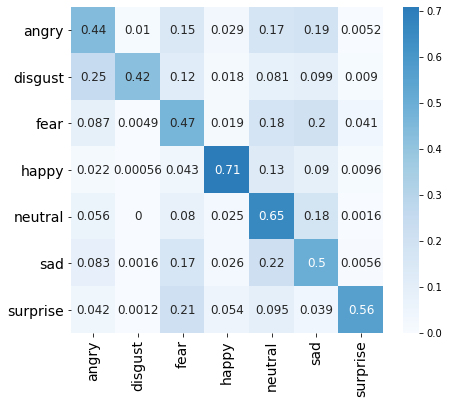

In [ ]:
test_transform = transforms.Compose([HistEqualization(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])
test_loader = CustomDataLoader(PATH_DATA, transformations=test_transform, batch_size=batch_size, as_df='test')

y_true, y_pred = test(model, device, PATH_MODELS, PATH_STATS, model_name)
confusion_plot(y_true, y_pred, PATH_FIG, model_name)


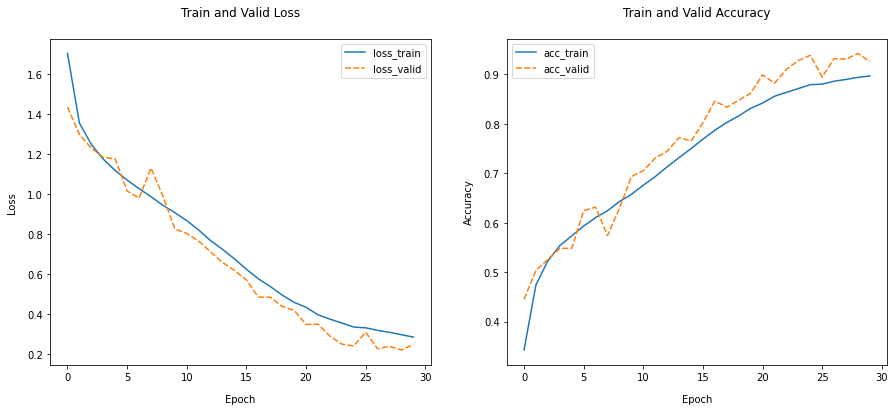

In [ ]:
show_trai_acc(PATH_STATS, PATH_FIG, model_name)

# Balancing:
In this section we try to deal with unbalanced database. **Use the NLLLoss in the Engine in the optimization section** and use balanced=True

In [ ]:
class Model(nn.Module):
  
  def __init__(self):
    
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, bias=False),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, bias=False),
        nn.Dropout(0.2),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, bias=False),
        nn.Dropout(0.2),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,  bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
  

        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, bias=False),
        nn.Dropout(0.2),

        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),
        nn.Flatten()
    )

    self.classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 7),
        nn.LogSoftmax(dim=-1)  
    )

  def forward(self,x):
    x=self.features(x)
    x=self.classifier(x)
    return x 

In [ ]:
# Initialize the mode
model = Model().to(device)
model.apply(weights_init)
summary(model, (3, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 46, 46]             432
       BatchNorm2d-2           [-1, 16, 46, 46]              32
              ReLU-3           [-1, 16, 46, 46]               0
            Conv2d-4           [-1, 32, 44, 44]           4,608
           Dropout-5           [-1, 32, 44, 44]               0
       BatchNorm2d-6           [-1, 32, 44, 44]              64
              ReLU-7           [-1, 32, 44, 44]               0
         MaxPool2d-8           [-1, 32, 22, 22]               0
            Conv2d-9           [-1, 64, 20, 20]          18,432
      BatchNorm2d-10           [-1, 64, 20, 20]             128
             ReLU-11           [-1, 64, 20, 20]               0
           Conv2d-12          [-1, 128, 18, 18]          73,728
          Dropout-13          [-1, 128, 18, 18]               0
      BatchNorm2d-14          [-1, 128,

In [ ]:
# Hyper Parameters:
model_name = 'balancing'
num_epochs = 80
batch_size = 80
learning_rate = 0.001
learning_rate_decay = 0.9
momentum = 0.0001
weight_decay = 0.0005
early_stopping = 30

In [ ]:
train_transform = transforms.Compose([HistEqualization(),                                      
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])
valid_transform = transforms.Compose([HistEqualization(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])

In [ ]:
run_train(num_epochs, early_stopping, train_transform, valid_transform, batch_size,
          model_name, PATH_STATS, PATH_MODELS, PATH_DATA, device, model,
          weight_decay=weight_decay, learning_rate=learning_rate, learning_rate_decay=learning_rate_decay,
          balanced=True)

Epoch: 1 Loss Train: 1.7246167714949008 Train Accuracy: 0.3407624859979142
Epoch: 1 Loss Validation: 1.6206651859813266 Validation Accuracy: 0.3723404255319149


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning:

The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.



Epoch: 2 Loss Train: 1.237332379008517 Train Accuracy: 0.5241994669550775
Epoch: 2 Loss Validation: 1.4358330137199826 Validation Accuracy: 0.4549645390070922
Epoch: 3 Loss Train: 1.086874336556152 Train Accuracy: 0.5894781567461084
Epoch: 3 Loss Validation: 1.3645738479163911 Validation Accuracy: 0.4975177304964539
Epoch: 4 Loss Train: 0.9943611653130732 Train Accuracy: 0.6218084900923172
Epoch: 4 Loss Validation: 1.2288379983769522 Validation Accuracy: 0.5237588652482269
Epoch: 5 Loss Train: 0.9450779516755798 Train Accuracy: 0.6407354474873498
Epoch: 5 Loss Validation: 1.1887348360485501 Validation Accuracy: 0.5570921985815603
Epoch: 6 Loss Train: 0.8886070514534726 Train Accuracy: 0.6647224690022789
Epoch: 6 Loss Validation: 1.195700776245859 Validation Accuracy: 0.5570921985815603
Epoch: 7 Loss Train: 0.8472506917185254 Train Accuracy: 0.6836494263973116
Epoch: 7 Loss Validation: 1.1856227094928424 Validation Accuracy: 0.5627659574468085
Epoch: 8 Loss Train: 0.7957440279884103 Tra

1.138083525829845

In [ ]:
test_transform = transforms.Compose([HistEqualization(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])
test_loader = CustomDataLoader(PATH_DATA, transformations=test_transform, batch_size=batch_size, as_df='test')

y_true, y_pred = test(model, device, PATH_MODELS, PATH_STATS, model_name)
confusion_plot(y_true, y_pred, PATH_FIG, model_name)


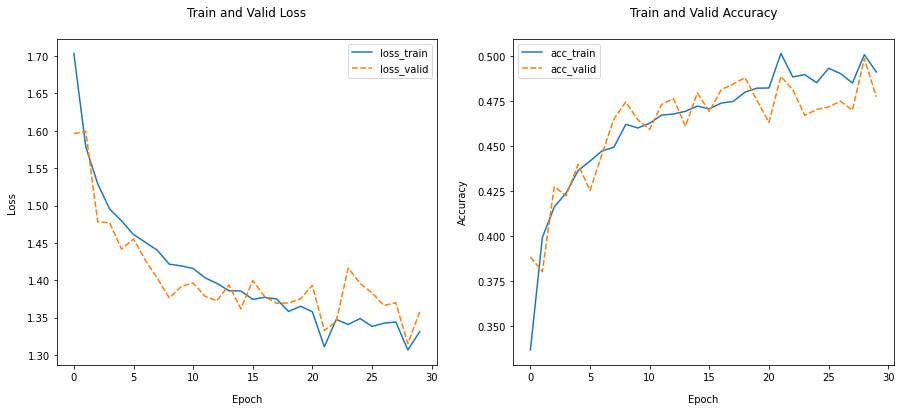

In [ ]:
show_trai_acc(PATH_STATS, PATH_FIG, model_name)

# Augmentation:
In this section we are going to apply some standard transformations to te image.

In [ ]:
class Model(nn.Module):
  
  def __init__(self):
    
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, bias=False),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, bias=False),
        nn.Dropout(0.2),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, bias=False),
        nn.Dropout(0.2),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,  bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
  

        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, bias=False),
        nn.Dropout(0.2),

        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),
        nn.Flatten()
    )

    self.classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 7),
    
    )

  def forward(self,x):
    x=self.features(x)
    x=self.classifier(x)
    return x 

In [ ]:
# Initialize the mode
model = Model().to(device)
model.apply(weights_init)
summary(model, (3, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 46, 46]             432
       BatchNorm2d-2           [-1, 16, 46, 46]              32
              ReLU-3           [-1, 16, 46, 46]               0
            Conv2d-4           [-1, 32, 44, 44]           4,608
           Dropout-5           [-1, 32, 44, 44]               0
       BatchNorm2d-6           [-1, 32, 44, 44]              64
              ReLU-7           [-1, 32, 44, 44]               0
         MaxPool2d-8           [-1, 32, 22, 22]               0
            Conv2d-9           [-1, 64, 20, 20]          18,432
      BatchNorm2d-10           [-1, 64, 20, 20]             128
             ReLU-11           [-1, 64, 20, 20]               0
           Conv2d-12          [-1, 128, 18, 18]          73,728
          Dropout-13          [-1, 128, 18, 18]               0
      BatchNorm2d-14          [-1, 128,

In [ ]:
# Hyper Parameters:
model_name = 'augmented'
num_epochs = 50
batch_size = 80
learning_rate = 0.001
learning_rate_decay = 0.9
momentum = 0.0001
weight_decay = 0.0005
early_stopping = 30

In [ ]:
train_transform = transforms.Compose([HistEqualization(),                                      
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomApply(torch.nn.ModuleList([transforms.RandomAffine(degrees=(-20, +20))]), p=0.5),
                                      transforms.RandomApply(torch.nn.ModuleList([transforms.RandomAffine(degrees=0, translate=(0.20,0.20))]), p=0.5),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])
valid_transform = transforms.Compose([HistEqualization(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])

In [ ]:
run_train(num_epochs, early_stopping, train_transform, valid_transform, batch_size,
          model_name, PATH_STATS, PATH_MODELS, PATH_DATA, device, model,
          weight_decay=weight_decay, learning_rate=learning_rate, learning_rate_decay=learning_rate_decay,
          balanced=False)

Epoch: 1 Loss Train: 1.8164352417728047 Train Accuracy: 0.2808528718760864
Epoch: 1 Loss Validation: 1.7129622186407631 Validation Accuracy: 0.29105025300320597


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 2 Loss Train: 1.572734785300714 Train Accuracy: 0.3774189810344162
Epoch: 2 Loss Validation: 1.6004249446186019 Validation Accuracy: 0.36227741511839007
Epoch: 3 Loss Train: 1.4476171787138339 Train Accuracy: 0.43744447448723395
Epoch: 3 Loss Validation: 1.6518633590068346 Validation Accuracy: 0.33601143342732437
Epoch: 4 Loss Train: 1.3730416938110634 Train Accuracy: 0.4726331646645293
Epoch: 4 Loss Validation: 1.4954387023125166 Validation Accuracy: 0.42547027695160106
Epoch: 5 Loss Train: 1.3213631576961942 Train Accuracy: 0.49488199621460854
Epoch: 5 Loss Validation: 1.3498552921745512 Validation Accuracy: 0.4845687357564989
Epoch: 6 Loss Train: 1.2837024456189003 Train Accuracy: 0.5102553207926146
Epoch: 6 Loss Validation: 1.4059803009401133 Validation Accuracy: 0.4740237166364093
Epoch: 7 Loss Train: 1.2580185249263858 Train Accuracy: 0.5214183630113175
Epoch: 7 Loss Validation: 1.4449326658138522 Validation Accuracy: 0.4618177604387964
Epoch: 8 Loss Train: 1.2333897278632

0.9583391475456732

           precision    recall  f1-score  accuracy
augmented   0.623145  0.570836  0.578139  0.623572


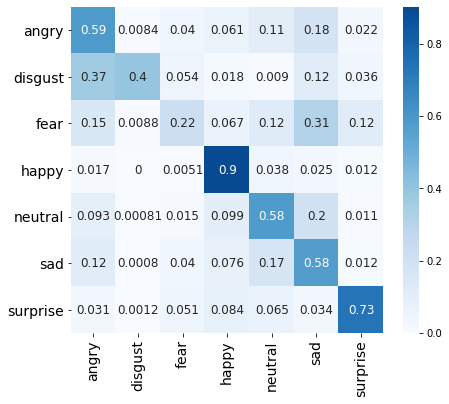

In [ ]:
test_transform = transforms.Compose([HistEqualization(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])
test_loader = CustomDataLoader(PATH_DATA, transformations=test_transform, batch_size=batch_size, as_df='test')

y_true, y_pred = test(model, device, PATH_MODELS, PATH_STATS, model_name)
confusion_plot(y_true, y_pred, PATH_FIG, model_name)


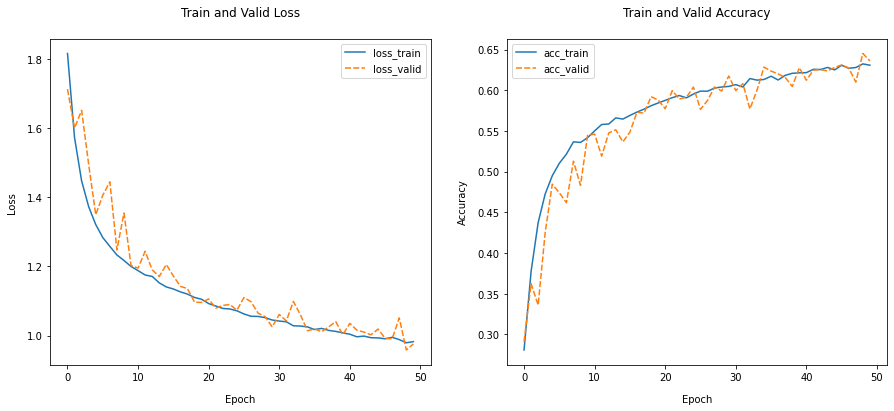

In [ ]:
show_trai_acc(PATH_STATS, PATH_FIG, model_name)

# Balancing and Augmentation
Combine both techinuqyes and use CrossEntropy (remember to enable it)

In [ ]:
class Model(nn.Module):
  
  def __init__(self):
    
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, bias=False),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, bias=False),
        nn.Dropout(0.2),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, bias=False),
        nn.Dropout(0.2),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,  bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
  

        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, bias=False),
        nn.Dropout(0.2),

        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),
        nn.Flatten()
    )

    self.classifier = nn.Sequential(
        nn.Dropout(0.3),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.Linear(512, 7),
  
    )

  def forward(self,x):
    x=self.features(x)
    x=self.classifier(x)
    return x 

In [ ]:
# Initialize the mode
model = Model().to(device)
model.apply(weights_init)
summary(model, (3, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 46, 46]             432
       BatchNorm2d-2           [-1, 16, 46, 46]              32
              ReLU-3           [-1, 16, 46, 46]               0
            Conv2d-4           [-1, 32, 44, 44]           4,608
           Dropout-5           [-1, 32, 44, 44]               0
       BatchNorm2d-6           [-1, 32, 44, 44]              64
              ReLU-7           [-1, 32, 44, 44]               0
         MaxPool2d-8           [-1, 32, 22, 22]               0
            Conv2d-9           [-1, 64, 20, 20]          18,432
      BatchNorm2d-10           [-1, 64, 20, 20]             128
             ReLU-11           [-1, 64, 20, 20]               0
           Conv2d-12          [-1, 128, 18, 18]          73,728
          Dropout-13          [-1, 128, 18, 18]               0
      BatchNorm2d-14          [-1, 128,

In [ ]:
# Hyper Parameters:
model_name = 'balancing_augmented'
num_epochs = 100
batch_size = 80
learning_rate = 0.001
learning_rate_decay = 0.9
momentum = 0.0001
weight_decay = 0.0005
early_stopping = 40

In [ ]:
train_transform = transforms.Compose([HistEqualization(),                                      
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomApply(torch.nn.ModuleList([transforms.RandomAffine(degrees=(-20, +20))]), p=0.5),
                                      transforms.RandomApply(torch.nn.ModuleList([transforms.RandomAffine(degrees=0, translate=(0.20,0.20))]), p=0.5),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])
valid_transform = transforms.Compose([HistEqualization(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])

In [ ]:
run_train(num_epochs, early_stopping, train_transform, valid_transform, batch_size,
          model_name, PATH_STATS, PATH_MODELS, PATH_DATA, device, model,
          weight_decay=weight_decay, learning_rate=learning_rate, learning_rate_decay=learning_rate_decay,
          balanced=True)

Epoch: 1 Loss Train: 1.950254953937766 Train Accuracy: 0.2280118969446483
Epoch: 1 Loss Validation: 1.80264926287863 Validation Accuracy: 0.2946808510638298


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 2 Loss Train: 1.6514603477201344 Train Accuracy: 0.3535864652941404
Epoch: 2 Loss Validation: 1.676699264181985 Validation Accuracy: 0.34893617021276596
Epoch: 3 Loss Train: 1.5135042520216953 Train Accuracy: 0.41550465448646146
Epoch: 3 Loss Validation: 1.4664077030287848 Validation Accuracy: 0.4418439716312057
Epoch: 4 Loss Train: 1.439666058914161 Train Accuracy: 0.4479508671636602
Epoch: 4 Loss Validation: 1.8633151650428772 Validation Accuracy: 0.3170212765957447
Epoch: 5 Loss Train: 1.3537351308781425 Train Accuracy: 0.48209664336204566
Epoch: 5 Loss Validation: 1.2404720816347334 Validation Accuracy: 0.5273049645390071
Epoch: 6 Loss Train: 1.3150132990177767 Train Accuracy: 0.49731546216539846
Epoch: 6 Loss Validation: 1.2588644896944363 Validation Accuracy: 0.5290780141843971
Epoch: 7 Loss Train: 1.2864104722752983 Train Accuracy: 0.5072038317432114
Epoch: 7 Loss Validation: 1.2706964545779758 Validation Accuracy: 0.526595744680851
Epoch: 8 Loss Train: 1.2348888472274497

0.9761074723468887

                     precision    recall  f1-score  accuracy
balancing_augmented   0.584629  0.608715  0.590169  0.610059


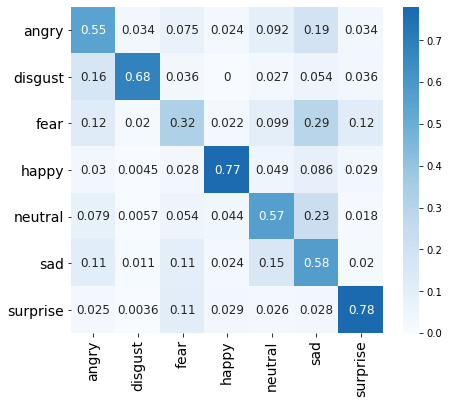

In [ ]:
test_transform = transforms.Compose([HistEqualization(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])
test_loader = CustomDataLoader(PATH_DATA, transformations=test_transform, batch_size=batch_size, as_df='test')

y_true, y_pred = test(model, device, PATH_MODELS, PATH_STATS, model_name)
confusion_plot(y_true, y_pred, PATH_FIG, model_name)


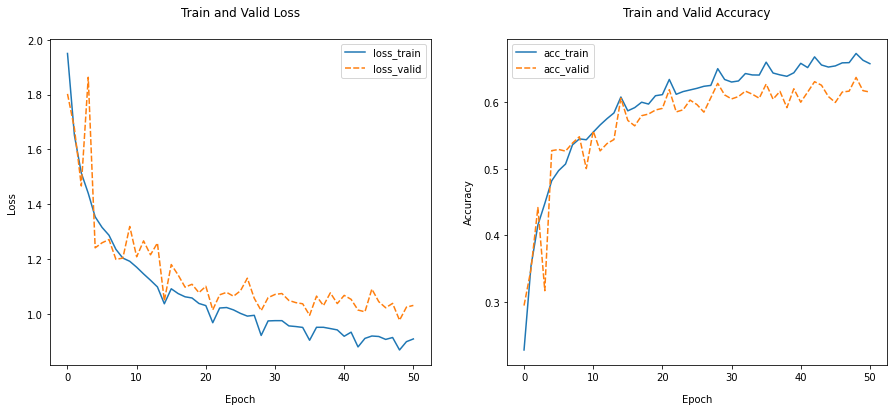

In [ ]:
show_trai_acc(PATH_STATS, PATH_FIG, model_name)

# VGG 11

When you train it, you must use CrossEntropyLoss, so **change it in the Enigne in the Optimizer Section** (default is NLLL).
After loading the whole network, we keep the feature part, but the last MaxPool. We add a AvgGlobalPool that returns as shape (512, 2, 2).
The classifier is completly redesigned to this task, made by 3 Layers 2048-->1024, 1024-->512, 512-->7. With a 30% Dropout between the first two layers.

In [ ]:
model = torchvision.models.vgg11(pretrained=True)
set_parameter_requires_grad(model.features, True)
model = nn.Sequential(*list(model.features._modules.values())[:-1])
model.avgpool = nn.AvgPool2d(2,1)
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Linear(512, 7)
    )

model = model.to(device)
#model.apply(weights_init)
summary(model, (3,48,48))


Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /root/.cache/torch/hub/checkpoints/vgg11-bbd30ac9.pth



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 48, 48]           1,792
              ReLU-2           [-1, 64, 48, 48]               0
         MaxPool2d-3           [-1, 64, 24, 24]               0
            Conv2d-4          [-1, 128, 24, 24]          73,856
              ReLU-5          [-1, 128, 24, 24]               0
         MaxPool2d-6          [-1, 128, 12, 12]               0
            Conv2d-7          [-1, 256, 12, 12]         295,168
              ReLU-8          [-1, 256, 12, 12]               0
            Conv2d-9          [-1, 256, 12, 12]         590,080
             ReLU-10          [-1, 256, 12, 12]               0
        MaxPool2d-11            [-1, 256, 6, 6]               0
           Conv2d-12            [-1, 512, 6, 6]       1,180,160
             ReLU-13            [-1, 512, 6, 6]               0
           Conv2d-14            [-1, 5

In [ ]:
# Hyper Parameters:
model_name = 'VGG11'
num_epochs = 30
batch_size = 120
learning_rate = 0.001
learning_rate_decay = 0.9
momentum = 0.0001
weight_decay = 0.0005
early_stopping = 20

In [ ]:
train_transform = transforms.Compose([HistEqualization(),                    
                                      transforms.RandomHorizontalFlip(p=0.7),
                                      transforms.RandomApply(torch.nn.ModuleList([transforms.RandomAffine(degrees=(-20, +20))]), p=0.3),
                                      transforms.RandomApply(torch.nn.ModuleList([transforms.RandomAffine(degrees=0, translate=(0.20,0.20))]), p=0.5),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
valid_transform = transforms.Compose([HistEqualization(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
run_train(num_epochs, early_stopping, train_transform, valid_transform, batch_size,
          model_name, PATH_STATS, PATH_MODELS, PATH_DATA, device, model,
          weight_decay=weight_decay, learning_rate=learning_rate, learning_rate_decay=learning_rate_decay,
          balanced=True)

Epoch: 1 Loss Train: 1.7034340120024152 Train Accuracy: 0.3366294565259377
Epoch: 1 Loss Validation: 1.5961117992798488 Validation Accuracy: 0.3882978723404255


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning:

The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.



Epoch: 2 Loss Train: 1.578391882556456 Train Accuracy: 0.39904978948588204
Epoch: 2 Loss Validation: 1.5991160770257313 Validation Accuracy: 0.3801418439716312
Epoch: 3 Loss Train: 1.529119137260649 Train Accuracy: 0.41612267758507476
Epoch: 3 Loss Validation: 1.47814229875803 Validation Accuracy: 0.42730496453900707
Epoch: 4 Loss Train: 1.4952017808402027 Train Accuracy: 0.42388659276140445
Epoch: 4 Loss Validation: 1.4767941335837047 Validation Accuracy: 0.4223404255319149
Epoch: 5 Loss Train: 1.479375492091532 Train Accuracy: 0.43632430762099733
Epoch: 5 Loss Validation: 1.4416888679067295 Validation Accuracy: 0.4397163120567376
Epoch: 6 Loss Train: 1.4611230304947607 Train Accuracy: 0.44157750395921047
Epoch: 6 Loss Validation: 1.4551317244768143 Validation Accuracy: 0.425177304964539
Epoch: 7 Loss Train: 1.4506735454003017 Train Accuracy: 0.4472169647340569
Epoch: 7 Loss Validation: 1.426607606311639 Validation Accuracy: 0.4453900709219858
Epoch: 8 Loss Train: 1.440071475726587 Tr

1.315073197086652

       precision    recall  f1-score  accuracy
VGG11   0.418299  0.479498  0.426693  0.468236


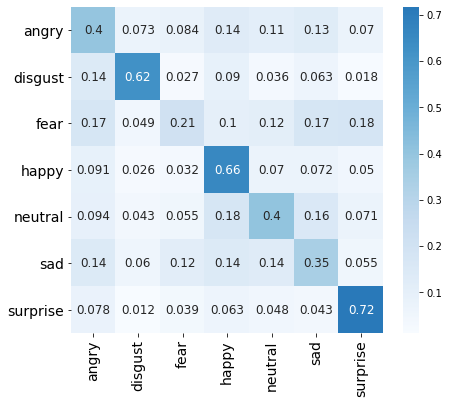

In [ ]:
#Evaluate the model:
test_transform = transforms.Compose([HistEqualization(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])
test_loader = CustomDataLoader(PATH_DATA, transformations=test_transform, batch_size=batch_size, as_df='test')

y_true, y_pred = test(model, device, PATH_MODELS, PATH_STATS, model_name)
confusion_plot(y_true, y_pred, PATH_FIG, model_name)


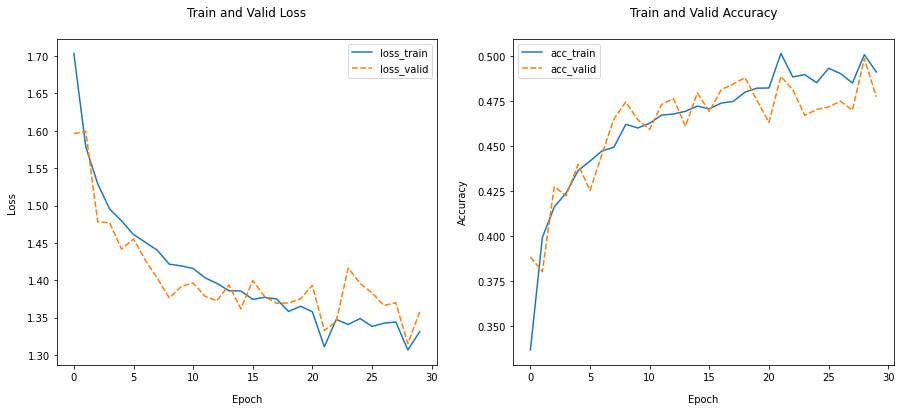

In [ ]:
show_trai_acc(PATH_STATS, PATH_FIG, model_name)

# ResNet:

In [ ]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=True)
set_parameter_requires_grad(model, True)
model.fc = nn.Linear(512, 7)
model = model.to(device)
summary(model, (3, 48, 48))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           9,408
       BatchNorm2d-2           [-1, 64, 24, 24]             128
              ReLU-3           [-1, 64, 24, 24]               0
         MaxPool2d-4           [-1, 64, 12, 12]               0
            Conv2d-5           [-1, 64, 12, 12]          36,864
       BatchNorm2d-6           [-1, 64, 12, 12]             128
              ReLU-7           [-1, 64, 12, 12]               0
            Conv2d-8           [-1, 64, 12, 12]          36,864
       BatchNorm2d-9           [-1, 64, 12, 12]             128
             ReLU-10           [-1, 64, 12, 12]               0
       BasicBlock-11           [-1, 64, 12, 12]               0
           Conv2d-12           [-1, 64, 12, 12]          36,864
      BatchNorm2d-13           [-1, 64, 12, 12]             128
             ReLU-14           [-1, 64,

In [ ]:
# Hyper Parameters:
model_name = 'RES18'
num_epochs = 50
batch_size = 100
learning_rate = 0.001
learning_rate_decay = 0.9
momentum = 0.0001
weight_decay = 0.0005
early_stopping = 20

In [ ]:
train_transform = transforms.Compose([HistEqualization(),                    
                                      transforms.RandomHorizontalFlip(p=0.7),
                                      transforms.RandomApply(torch.nn.ModuleList([transforms.RandomAffine(degrees=(-20, +20))]), p=0.5),
                                      transforms.RandomApply(torch.nn.ModuleList([transforms.RandomAffine(degrees=0, translate=(0.20,0.20))]), p=0.5),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
valid_transform = transforms.Compose([HistEqualization(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
run_train(num_epochs, early_stopping, train_transform, valid_transform, batch_size,
          model_name, PATH_STATS, PATH_MODELS, PATH_DATA, device, model,
          weight_decay=weight_decay, learning_rate=learning_rate, learning_rate_decay=learning_rate_decay, 
          balanced=True)

Epoch: 1 Loss Train: 1.8192471988412864 Train Accuracy: 0.2716984047278767
Epoch: 1 Loss Validation: 1.7474073236053054 Validation Accuracy: 0.29947081772181233


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 2 Loss Train: 1.7447167317379395 Train Accuracy: 0.30576692803893546
Epoch: 2 Loss Validation: 1.7237880842105762 Validation Accuracy: 0.31411023987021514
Epoch: 3 Loss Train: 1.7310301926145222 Train Accuracy: 0.3099385839545753
Epoch: 3 Loss Validation: 1.7141096154695312 Validation Accuracy: 0.31534628606744175
Epoch: 4 Loss Train: 1.7239794496403698 Train Accuracy: 0.31438062497585845
Epoch: 4 Loss Validation: 1.7115286243468177 Validation Accuracy: 0.3237668507860481
Epoch: 5 Loss Train: 1.7179413150176117 Train Accuracy: 0.3146510100815018
Epoch: 5 Loss Validation: 1.701887523805773 Validation Accuracy: 0.3240758623353548
Epoch: 6 Loss Train: 1.7115426348903464 Train Accuracy: 0.31928618332110165
Epoch: 6 Loss Validation: 1.7134564493613813 Validation Accuracy: 0.31716172891961836
Epoch: 7 Loss Train: 1.718959423105689 Train Accuracy: 0.31507590096179844
Epoch: 7 Loss Validation: 1.705101220303981 Validation Accuracy: 0.31905442465912165
Epoch: 8 Loss Train: 1.713265736590

1.6873711660561874

       precision    recall  f1-score  accuracy
RES18    0.26972  0.254456  0.244076  0.322095


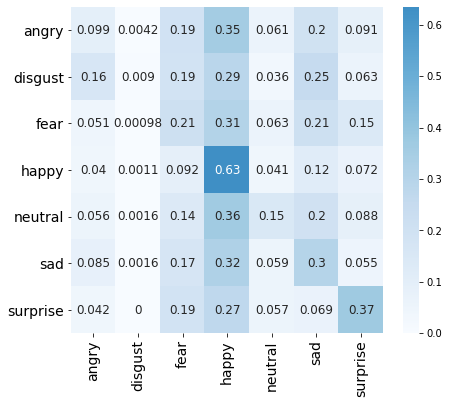

In [ ]:
#Evaluate the model:
test_transform = transforms.Compose([HistEqualization(),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                    ])
test_loader = CustomDataLoader(PATH_DATA, transformations=test_transform, batch_size=batch_size, as_df='test')

y_true, y_pred = test(model, device, PATH_MODELS, PATH_STATS, model_name)
confusion_plot(y_true, y_pred, PATH_FIG, model_name)


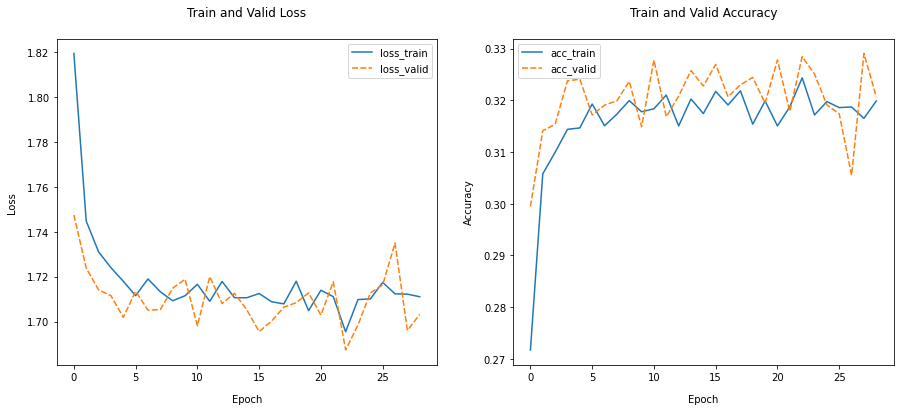

In [ ]:
show_trai_acc(PATH_STATS, PATH_FIG, model_name)

# Interpretability:


In [ ]:
class Model(nn.Module):
  
  def __init__(self):
    
    super().__init__()

    self.features = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3,  bias=False),
        nn.BatchNorm2d(16),
        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, bias=False),
        nn.Dropout(0.2),
        nn.BatchNorm2d(32),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(inplace=True),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, bias=False),
        nn.Dropout(0.2),
        nn.BatchNorm2d(128),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3,  bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
  

        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3,  bias=False),
        nn.Dropout(0.2),

        nn.BatchNorm2d(256),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2, 2),
        nn.Flatten()
    )

    self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(512, 7),
    )

  def forward(self,x):
    x=self.features(x)
    x=self.classifier(x)
    return x 

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)
model.load_state_dict(torch.load("augmented.ckpt"))
model.eval()

In [ ]:
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [ ]:
class Grad_CAM(nn.Module):
    def __init__(self,model,index_1,data_folder):
        """

        :param model: model that will dissect
        :param index_1: index of the last activation function of the
        feature map
        """
        super().__init__()
        self.model=model
        self.class_labels={data_folder.class_to_idx[key]:key for key in data_folder.class_to_idx }
        #layers until the last activation layer
        self.features_conv = self.model.features[:index_1]

        ## remaining part of the layers
        self.remaining_part_of_features=self.model.features[index_1:]
        self.classifier = self.model.classifier

        ##Gradient of the Last Activation
        self.last_layer_activadtion_gr=None


        #key : path
        #values predicted,GT
        self.wrong_classified_img_info=[]

    def activations_hook(self,grad):
        self.last_layer_activadtion_gr=grad


    def forward(self,x):
        x=self.features_conv(x)
        self.activation_map=x.detach().clone()
        hook = x.register_hook(self.activations_hook)
        x=self.remaining_part_of_features(x)
        x=self.classifier(x)
        return x

    def calculate_color_map(self,prediction):
      ## send gradient backward according to the mostly probable class
      prediction[:,torch.argmax(prediction)].backward()
      pooled_gradient=torch.mean(self.last_layer_activadtion_gr,dim=[0, 2, 3])
      for i in range(pooled_gradient.shape[0]):
        self.activation_map[:, i, :, :] *= pooled_gradient[i]
      heatmap = torch.mean(self.activation_map, dim=1).squeeze().cpu()
      heatmap = np.maximum(heatmap, 0)
      heatmap /= torch.max(heatmap)
      return heatmap
    
    def write_images_related_file(self,prediction,ground_truth,path_to_img):
      heatmap=self.calculate_color_map(prediction)
      original_img=cv2.imread(path_to_img[0])
      heatmap = cv2.resize(heatmap.numpy(), (original_img.shape[1], original_img.shape[0]))
      heatmap = np.uint8(255 * heatmap)
      heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
      superimposed_img = heatmap * 0.4 + original_img

      file_name="-".join(path[0].split("/")[4:])
      if  torch.argmax(prediction).cpu().item() == ground_truth.cpu().item():
        cv2.imwrite(f'/content/Gan_Result/correct/{file_name}', superimposed_img)
      else:

        gt_label=path[0].split("/")[5]
        predicted_label = torch.argmax(prediction).cpu().item()
        self.wrong_classified_img_info.append([
                                                   path[0],
                                                   self.class_labels[predicted_label],
                                                   gt_label
                                                  ] )
        cv2.imwrite(f'/content/Gan_Result/wrong/{file_name}', superimposed_img)


#height, width, channels cv2 
#channels, height, width pytorch


In [ ]:
Grad=Grad_CAM(model,23,test_images)

for idx,(img, label,path) in enumerate(test_gen):
    img = img.to(device)
    label = label.to(device)
    prediction = Grad(img)
    
    Grad.write_images_related_file(prediction,label,path)
    

In [ ]:
import pandas as pd 
result_analysis=pd.DataFrame(Grad.wrong_classified_img_info,columns=["path",
                                                     "predicted",
                                                     "GroundTr"])
result_analysis.to_csv("wrongly_classified.csv",index=False)